In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html 

# Task 5

In [2]:
df = pd.read_csv(
    r"C:\Users\Abdullah\OneDrive\Documents\UoM\Data engineering\Datasets\rawpvr_2018-02-01_28d_1083 TueFri.csv")

# Convert date column from text into datetime type
df['Date']=pd.to_datetime(df['Date'])

"""Data preparation step: Renaming the column headers so that its 1 continuous string"""
#Renaming column headers to make it easier to work with
df.rename(columns = {'Lane Name':'Lane_name','Direction Name':'Direction_name','Speed (mph)':'Speed_mph', 
                     'Headway (s)':'Headway_s','Gap (s)': 'Gap_s','Flag Text':'Flag_text'}, inplace = True)

# Using datetimes weekday method to get the weekday of our date
df['Flags'] = df['Date'].dt.weekday +1 # had to +1 as dt.weekday has days from 0 to 6
# Returning the name of the day of week
df['Flag_text']= df['Date'].dt.day_name()


## Part I.

In [3]:
"""Defining a function that filters the dataframe based on the dataframe itself, the day, the start and end times
and direction (which is given a default value as it's an optional argument). Making a function like this may
seem cumbersome, but it helps a lot in the future tasks when I need to filter on different dataframes and 
conditions. This function hugely helps in the data preparation steps as I don't need to keep creating multiple
global variables which are similar to each other.""" 
# Function for filtering a dataframe by day, starting/end time and the direction
def filter_df(df,day,start_time,end_time,direction=3):
    
    if direction==3: # If the direction flag is set to default then
        fil_df = df.loc[(df['Flags']== day) & (df['Direction']<direction)] # This filters on all direction 
        # values less than 3 (all lanes in this case)
    else:
        fil_df = df.loc[(df['Flags']== day) & (df['Direction']==direction)] # If a direction argument is passed
        # into the function then this filters on the specified direction
        
    filtered_df= fil_df.set_index('Date').between_time(start_time,end_time).reset_index()
    """Need to set the index to a datetime index first as otherwise the .betweeen_time() function won't work - 
    once the function is performed, we will reset the index with the reset_index() method."""
    
    return filtered_df

# Filtering the dataframe for Tuesdays (value 2 for flags) and for the time between 7:00 - 19:00:00
filtered_df= filter_df(df,2,'7:00:00','19:00:00')
# Now we have a filtered dataframe for the north lanes with all specified conditions
filtered_df

,Date,Lane,Lane_name,Direction,Direction_name,Speed_mph,Headway_s,Gap_s,Flags,Flag_text
0,2018-02-06 07:00:00.100,3,NB_OS,1,North,32.310,3.462,NaN,2,Tuesday
1,2018-02-06 07:00:01.160,2,NB_MID,1,North,27.962,1.720,NaN,2,Tuesday
2,2018-02-06 07:00:03.000,2,NB_MID,1,North,27.962,2.480,1.992,2,Tuesday
3,2018-02-06 07:00:03.020,4,SB_OS,2,South,47.846,NaN,NaN,2,Tuesday
4,2018-02-06 07:00:03.030,1,NB_NS,1,North,27.340,4.418,NaN,2,Tuesday
...,...,...,...,...,...,...,...,...,...,...
201120,2018-02-27 18:59:56.010,6,SB_NS,2,South,33.554,3.467,3.001,2,Tuesday
201121,2018-02-27 18:59:57.050,6,SB_NS,2,South,33.554,1.633,1.127,2,Tuesday
201122,2018-02-27 18:59:58.040,1,NB_NS,1,North,19.884,5.400,5.182,2,Tuesday
201123,2018-02-27 18:59:58.060,2,NB_MID,1,North,43.495,7.600,7.307,2,Tuesday


In [4]:
# Calculating column completeness
col_completeness = (filtered_df.Gap_s.notnull().sum()*100) / len(filtered_df.Gap_s)
print(f"The level of completeness of the Gap_s column is: {round(col_completeness,2)}%")


The level of completeness of the Gap_s column is: 98.04%


In [5]:
# Filtering the data by the MID lane and day 6
df_filtered= filtered_df.loc[(filtered_df['Lane_name']=='NB_MID') & (filtered_df['Date'].dt.day==6)]
df_filtered

,Date,Lane,Lane_name,Direction,Direction_name,Speed_mph,Headway_s,Gap_s,Flags,Flag_text
1,2018-02-06 07:00:01.160,2,NB_MID,1,North,27.962,1.720,NaN,2,Tuesday
2,2018-02-06 07:00:03.000,2,NB_MID,1,North,27.962,2.480,1.992,2,Tuesday
5,2018-02-06 07:00:04.020,2,NB_MID,1,North,27.962,1.520,0.856,2,Tuesday
8,2018-02-06 07:00:05.020,2,NB_MID,1,North,29.205,1.226,0.680,2,Tuesday
13,2018-02-06 07:00:07.020,2,NB_MID,1,North,29.825,2.137,1.694,2,Tuesday
...,...,...,...,...,...,...,...,...,...,...
51470,2018-02-06 18:59:34.020,2,NB_MID,1,North,34.798,16.500,16.140,2,Tuesday
51475,2018-02-06 18:59:36.030,2,NB_MID,1,North,33.554,2.400,1.817,2,Tuesday
51478,2018-02-06 18:59:38.010,2,NB_MID,1,North,38.525,1.742,1.487,2,Tuesday
51485,2018-02-06 18:59:44.080,2,NB_MID,1,North,32.932,4.381,5.450,2,Tuesday


# ----------------------------------------------------------------------------------------------------------

## Part II.

In [6]:

# Function for grouping by the hour and calculating the measurement (mean or median) for that hour
"""The first part groups the dataframe by hour and then the as_index argument makes sure the hour isn't used
as the index. This is so I can modify the hour column however I want. After that we select the measurement 
for the column for each hour its been grouped by (e.g with ['Gap_s'].mean()) """
def hourly_avg(df,column_name, measurement):
    
    # Depending on what user specifies the measurement to be the mean or median will be calculated.
    if measurement == 'mean':
        hours = df.groupby(df['Date'].dt.hour,as_index=False)[column_name].mean()
    elif measurement== 'median':
        hours = df.groupby(df['Date'].dt.hour,as_index=False)[column_name].median()

    """Before outputting the dataframe, I will replace all the hour values (e.g 7, 8, 17) with a range so we know 
    exactly what time frame the average gap is for."""
    intervals = []
    for i in df['Date'].dt.hour.unique():
        intervals.append(f"{i}:00 - {i+1}:00")

    hours['Hour'] = intervals
    return hours

# Calling the function for the 'Gap_s' column with mean as the measurement
hours= hourly_avg(df_filtered,'Gap_s', 'mean')
display(hours)

,Gap_s,Hour
0,2.496818,7:00 - 8:00
1,3.131625,8:00 - 9:00
2,3.582956,9:00 - 10:00
3,4.783773,10:00 - 11:00
4,4.905498,11:00 - 12:00
5,4.954593,12:00 - 13:00
6,4.696553,13:00 - 14:00
7,5.338563,14:00 - 15:00
8,6.175825,15:00 - 16:00
9,4.890346,16:00 - 17:00


The first dataframe is the mean gap (s) per hour whereas the 2nd dataframe is the median gap per hour. To continue with the data profiling process, I'll plot some charts.

In [7]:
df_filtered

,Date,Lane,Lane_name,Direction,Direction_name,Speed_mph,Headway_s,Gap_s,Flags,Flag_text
1,2018-02-06 07:00:01.160,2,NB_MID,1,North,27.962,1.720,NaN,2,Tuesday
2,2018-02-06 07:00:03.000,2,NB_MID,1,North,27.962,2.480,1.992,2,Tuesday
5,2018-02-06 07:00:04.020,2,NB_MID,1,North,27.962,1.520,0.856,2,Tuesday
8,2018-02-06 07:00:05.020,2,NB_MID,1,North,29.205,1.226,0.680,2,Tuesday
13,2018-02-06 07:00:07.020,2,NB_MID,1,North,29.825,2.137,1.694,2,Tuesday
...,...,...,...,...,...,...,...,...,...,...
51470,2018-02-06 18:59:34.020,2,NB_MID,1,North,34.798,16.500,16.140,2,Tuesday
51475,2018-02-06 18:59:36.030,2,NB_MID,1,North,33.554,2.400,1.817,2,Tuesday
51478,2018-02-06 18:59:38.010,2,NB_MID,1,North,38.525,1.742,1.487,2,Tuesday
51485,2018-02-06 18:59:44.080,2,NB_MID,1,North,32.932,4.381,5.450,2,Tuesday


In [8]:
# Now taking an average over all hours
print(f"The average gap over all hours between 7:00 - 19:00: {round(hours['Gap_s'].mean(),3)} seconds")

The average gap over all hours between 7:00 - 19:00: 4.5 seconds


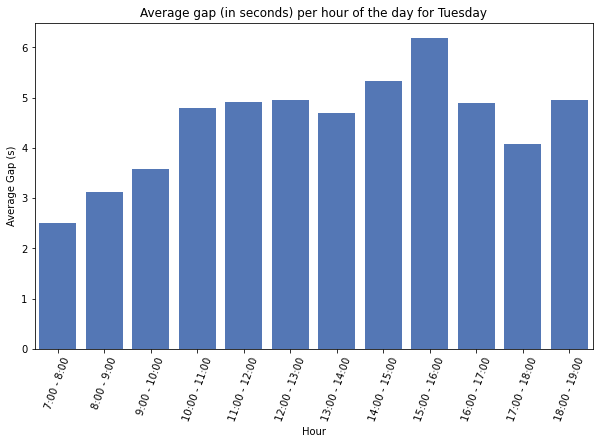

In [9]:
# Creating a barchart for the per hour average gap for the Tuesday
plt.figure(figsize = (10,6))
ax = sns.barplot(data=hours,x="Hour",y="Gap_s", color='#4473C5');
ax.set_title('Average gap (in seconds) per hour of the day for Tuesday');
ax.set(xlabel='Hour', ylabel='Average Gap (s)')
plt.xticks(rotation=70);

In [10]:
# Some more profiling, but this time for the median gap for each hour
plt.figure(figsize = (10,6))
ax_median = sns.barplot(data=hours_median,x="Hour",y="Gap_s", color='#4473C5');
ax_median.set_title('Median gap (in seconds) per hour of the day for Tuesday');
ax_median.set(xlabel='Hour', ylabel='Median Gap (s)')
plt.xticks(rotation=70);

NameError: name 'hours_median' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
# Getting the mean (average) of the per hour gap data to see the average gap (s) over all the hours between 7:00 - 19:00
print(f"Average median gap (in seconds) over all hours between 7:00 and 19:00: {round(hours_median['Gap_s'].mean(),3)}")

# ----------------------------------------------------------------------------------------------------------

## Part III.

Let's explore the data first, getting the max and min values, range and median.
Method chosen to fill in the missing values: Median value of the column

The strategy was based upon the data having major outliers (which could have a considerable effect on the mean).
To validate this, I'll calculate some values and plot some graphs as a means of exploratory data analysis.

In [ ]:
# Calculating some descriptive statistics
print(f"Median: {round(df_filtered['Gap_s'].median(),3)}")
print(f"Mean: {round(df_filtered['Gap_s'].mean(),3)}")

print(f"3rd quartile: {round(df_filtered['Gap_s'].quantile(0.75),3)}")

print(f"Range: {round(df_filtered['Gap_s'].max()-df_filtered['Gap_s'].min(),3)}")
print(f"Min: {round(df_filtered['Gap_s'].min(),3)}")
print(f"Max: {round(df_filtered['Gap_s'].max(),3)}")

From this, we can see that the mean is 4.295 and median 2.14, the range is 88.06 which is a huge range just for the number of seconds between cars. This gives us a high variability and hence it'd be difficult to calculate central tendency using mean. The range is not a good indicator of central tendency anyway, it doesn't tell us how many cars had a gap above a certain value.

Also, 75% of all cars have a gap of less than 4.12 (s) which is less than the mean we're getting (4.295) which tells us in this case the mean won't be a good indicator of the average needed to fill in the missing rows. If we used the mean in this case it'd skew the results a bit higher and the 3rd quartile would become higher, resulting in an inaccurate representation of the data. 

In [ ]:
#A quick density plot to see the distribution of the gap seconds. 
plt.figure(figsize=(12,8));
sns.histplot(data=df_filtered, x="Gap_s",kde=True).set_title('Distribution plot for the gap');

In [ ]:
print(f"Number of occurences above 40 seconds: {df_filtered.loc[df_filtered.Gap_s > 2.14, 'Gap_s'].count()}")

Looking at the density plot, we can quickly gauge that the data is skewed and not normally distributed. The majority of the data points are concentrated at 1 spot (around the 1 - 6 (s) range) and there are outliers way off from 20 - 88 second range. The median however, is unaffected even if there are outliers and so will be considered 
the best measure of central tendency and would intorduce less bias into the data if we 
fill in the missing values with this.

Even though the number of extreme outliers is very less, the average that gets calculated is very different (2.14 for median and a 4.295 mean)- the mean being double the amount of the median. Hence, it's safe to say for this particular use case that replacing the missing values with the median is more suitable.

In [ ]:
# # Making a boxplot
plt.figure(figsize=(12,7))
sns.boxplot(data=df_filtered, x="Gap_s").set_title("Boxplot for the gap (s)");

Here we can see huge concentration of data in the 0-5 second range and multiple outliers above 15 seconds. 

In the case of filling the missing values with a constant, it would be totally inappropriate in this case or any in general as it can mess up the data if needed in some regression analysis or other similar models. 

To apply my strategy, I will create a new column Gap_s median_imputed which will have all the gap values and also have the missing cells filled in with the median of the gap for the partcular hour the missing value is observed in.
E.g if a missing value is found in between the hours 7:00 - 8:00 then the median gap for that specific hour will be calculated and the missing value will be imputed with this value

# ----------------------------------------------------------------------------------------------------------

## Part IV.


In [ ]:
# Function for replacing missing values with the median
def median_impute(df,attr):
    """First we need to create a copy of the dataframe or a SettingWithCopyWarning will occur. This prepares the
    data for imputation""" 
    df= df.copy()
    
   
    """Grouping the data by the hour and calculating the median for the hour. The the groupby function gives me a
    Series object which I can then use .transform on to get the median for each of the groups (in this case the 
    groups being each hour between 7:00 - 19:00)"""
    groupedBy_hourly_median= df.groupby(df['Date'].dt.hour)[attr].transform('median')
    
    """Creating a new column for the gap where missing values have been filled in and filling in the missing
    values with the median for each specific hour"""
    df['Gap_s']= round(df[attr].fillna(groupedBy_hourly_median),3)

    return df


median_imputed_df = median_impute(df_filtered,'Gap_s')
median_imputed_df


## a.

In [ ]:
# Grouping the data by hour and calculating the mean for the median imputed gap column
median_imputed_hours=  hourly_avg(median_imputed_df,'Gap_s', 'mean')

df1_styler = hours.style.set_table_attributes("style='display:inline'").hide_index().set_caption(
    'Hourly gap average (not imputed)')
df2_styler = median_imputed_hours.style.set_table_attributes("style='display:inline'").hide_index().set_caption(
    'Hourly gap average (imputed)')

# Including a space in between the 2 dataframes so they're not totally side by side.
space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

In [ ]:
# print(f"Average gap (in seconds) over all hours between 7:00 and 19:00 (non-imputed data): {round(hours['Gap_s'].mean(),3)}")

# print(f"Average gap (in seconds) over all hours between 7:00 and 19:00: {round(median_imputed_hours['Gap_s'].mean(),3)}")

avg_prep=filter_df(df,2,'15:00:00','16:00:00',1) 

new_df= avg_prep.loc[(avg_prep['Lane_name']=='NB_MID') & (avg_prep['Date'].dt.day==6)]

print('For just the hour between 15:00 - 16:00:')
print(f"Max is: {round(new_df['Gap_s'].max(),3)}")
print(f"Min is: {round(new_df['Gap_s'].min(),3)}")
print(f"Mean is: {round(new_df['Gap_s'].mean(),3)}")
print(f"Median is: {round(new_df['Gap_s'].median(),3)}")
new_df

Profiling the new data, we get a very similar average hourly gap values, and the overall average gap over the 12 hours were also pretty much the same (4.46 seconds). 
I do believe the new data values reflect well on the measure of the gap between vehicles.

## b.


In [ ]:
# Plotting 2 plots of the hourly gap distribution. 1 for the original data and 1 for the new data with the
# missing values being imputed.
plt.figure(figsize = (17,8))

plt.subplot(1,2,1)
sns.barplot(data=hours,x="Hour",y="Gap_s", color='#4473C5').set_title(
    'Average gap (in seconds) per hour of the day for Tuesday');
plt.xticks(rotation=70);

plt.subplot(1,2,2)
sns.barplot(data=median_imputed_hours,x="Hour",y="Gap_s", color='#7463B5').set_title(
    'Average gap (in seconds) per hour of the day for Tuesday (imputed data)');
plt.xticks(rotation=70);


In [ ]:
print(f"Median: {round(df_filtered['Gap_s (imputed)'].median(),3)}")
print(f"Mean: {round(df_filtered['Gap_s (imputed)'].mean(),3)}")
#print(f"Mean: {df_filtered['Gap_s'].max()}")

print(f"3rd quartile: {round(df_filtered['Gap_s (imputed)'].quantile(0.75),3)}")
print(f"80th percentile: {round(df_filtered['Gap_s (imputed)'].quantile(0.8),3)}")


In [ ]:
df_filtered

# ----------------------------------------------------------------------------------------------------------

# Task 6
## Part I.

In [ ]:
# 6. Part I.
# Importing the 2nd csv as a dataframe (df_2)
df_2 = pd.read_csv(
    r"C:\Users\Abdullah\OneDrive\Documents\UoM\Data engineering\Datasets\rawpvr_2018-02-01_28d_1415 TueFri.csv")

# Convert date column from text into datetime type
df_2['Date']=pd.to_datetime(df_2['Date'])
"""Converted the date which was in text format to datetime object to make it easier to work with and manipulate
as the upcoming tasks need us to work with the dates and times."""

"""Data preparation step: Renaming the column headers so that its 1 continuous string"""
#Renaming column headers to make it easier to work with
df_2.rename(columns = {'Lane Name':'Lane_name','Direction Name':'Direction_name','Speed (mph)':'Speed_mph', 
                     'Headway (s)':'Headway_s','Gap (s)': 'Gap_s','Flag Text':'Flag_text'}, inplace = True)

# Using datetimes weekday method to get the weekday of our date
df_2['Flags'] = df_2['Date'].dt.weekday +1 # had to +1 as dt.weekday has days from 0 to 6
# Returning the name of the day of week
df_2['Flag_text']= df_2['Date'].dt.day_name()


In [ ]:
"""In this data prep step, I create a new dataframe called filtered_df_1415 and call the filter_df function I 
made previously with 5 as the day (Friday), the start and end times and passs in 1 as the direction (North)""" 
filtered_df_1415 = filter_df(df_2,5,'17:00:00','18:00:00',1)

"""Need to prepare site 1083s data too, by filtering on the specified conditions. This will be
assigned to a new dataframe called filtered_df_1083"""
filtered_df_1083= filter_df(df,5,'17:00:00','18:00:00',1)

"""Since we want the average speed of all north lanes, we will stack the 2 dataframes (site 1083
and site 1415) together. We can do this using the concat function""" 
all_north = pd.concat([filtered_df_1083,filtered_df_1415], ignore_index=True, axis=0)
all_north

In [ ]:
# Calculating the overall average speed in the hour of 17:00 - 18:00
avg_speed = all_north['Speed_mph'].mean()
print(f"The average speed is: {round(avg_speed,3)}")

"""To prepare the distance variable, we need to first convert it from kilometres to miles The conversion 
ratio for km to miles is 1km = 0.621371 miles""" 
conversion_ratio = 0.621371
# So the distance in miles is then
miles= 4.86* conversion_ratio

"""Calculating the journey time by dividing miles by average speed, and then multiply by 60 to give the time 
in minutes""" 
JT= (miles/avg_speed)*60
print(f"The typical Friday journey time between site 1083 and 1415 at times 17:00 - 18:00 is: {round(JT,3)} minutes")

# ----------------------------------------------------------------------------------------------------------
## Part II.
Question answered through comments explaining the data preparation steps and reasoning. Can be found throughout the code.

# ----------------------------------------------------------------------------------------------------------

# Task 7
## Part I.

Completeness can be measured by dividing the avaialble records /observations by the expected number of observations.
If we want it in percentage terms, we simply multiply it by 100.

Here's a row completeness formula that I've devised:
      
**Row completeness = total number of rows - Number of rows with at least 1 missing value *100 / total number of rows**

This gives the row completeness for each individual row. Then, to calculate the overall row completeness we sum all the row completeness values and calculate the mean of it.


An example: Consider a dataframe with 5 columns. We see that the first row of the data has values missing in the 3rd and 4th column. This gives the number of columns with empty cells as 2.


## Part II.

In [11]:
# Making an assessment of the level of row completeness, considering rows 
# associated with Tuesdays between 7:00 and 19:00

# Calculating the number of missing rows
num_missing= len(filtered_df[filtered_df.isna().any(axis=1)])
print(f"Number of missing rows: {num_missing}")

print(f"Total number of rows: {len(filtered_df)}")

"""Calculating the row completeness formula with the missing no. of rows and the length of filtered_df 
(our dataframe with rows filtered between 7:00 - 19:00)""" 

row_completeness= (len(filtered_df)-num_missing)*100/len(filtered_df)

print(f"The row completeness is: {round(row_completeness,2)}%")

Number of missing rows: 3958
Total number of rows: 201125
The row completeness is: 98.03%


# Part III.


Completeness is the measure of of the proportion/percentage of data that is missing from a dataset. It refers to how comprehensive a dataset is. For example, if column in a dataset has 100 rows and 20 of the rows have missing data, then the column is said to be 80% complete. This can be applied over multiple columns to get an overall completeness score.

The row completeness formula is the better measure of dataset completeness in certain scenarios. In the case of taking individual columns, the row completeness formula would be better as it gives an overall completeness of all rows (inclusive of any missing value in any of the columns). However, if we apply the column formula over multiple columns available in a dataset, we can get an average column completeness. In this case the column completeness formula would be more accurate in representing the completeness of the data.

With the row formula given above, it just measures the number of rows that has a missing value, whether the row has just 1 or multiple missing values the model will still take it as 1 (row with missing values). This could result in a lower estimate of the completeness of a dataset. In our case, let's look at the headway and gap column, there are instances where both the columns have a missing value, so this becomes 1 instance of a 'missing' row, when in reality 2 attributes are missing. So in this case, column completeness (with modifications) would be better.

However, as the current col completeness formula stands, it isn't a good indicator of completeness for the traffic data file as it only considers singular columns.
The row completeness formula works better as it gives a completeness measure of all the rows that have empty values and we can get a quick measure of the percent of rows that are complete in a dataset.

